In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(46)
torch.set_default_device(device)

device

'cuda'

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)
test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
X_train_not_normalized = train_data.data.float().to(device=device)
y_train = train_data.targets.to(device=device)
X_test_not_normalized = test_data.data.float().to(device=device)
y_test = test_data.targets.to(device=device)

X_train = (X_train_not_normalized - X_train_not_normalized.min()) / (
    X_train_not_normalized.max() - X_train_not_normalized.min()
)
X_test = (X_test_not_normalized - X_test_not_normalized.min()) / (
    X_test_not_normalized.max() - X_test_not_normalized.min()
)

In [3]:
class Teacher(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(
            in_features=784, out_features=1024, dtype=torch.float
        )
        self.layer_two = nn.Linear(
            in_features=1024, out_features=512, dtype=torch.float
        )
        self.layer_three = nn.Linear(
            in_features=512, out_features=10, dtype=torch.float
        )

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


class Student(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.activation_function = nn.ReLU()

        self.flatten = nn.Flatten()

        self.layer_one = nn.Linear(in_features=784, out_features=128, dtype=torch.float)
        self.layer_two = nn.Linear(in_features=128, out_features=64, dtype=torch.float)
        self.layer_three = nn.Linear(in_features=64, out_features=10, dtype=torch.float)

    def forward(self, x: torch.Tensor):
        out = self.flatten(x)
        out = self.activation_function(self.layer_one(out))
        out = self.activation_function(self.layer_two(out))
        out = self.layer_three(out)
        return out


teacher_model = Teacher()
student_model = Student()

teacher_model.load_state_dict(torch.load("./TeacherModel.pth"))

teacher_y_train_logits = teacher_model(X_train).float().detach()
teacher_y_train = torch.argmax(teacher_y_train_logits, dim=1).float().detach()
teacher_y_test_logits = teacher_model(X_test).float().detach()
teacher_y_test = torch.argmax(teacher_y_test_logits, dim=1).float().detach()

In [4]:
import math
import matplotlib.pyplot as plt
import time

EPOCHS = 10
ALPHA = 0.01
BATCH_SIZE = 32
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(student_model.parameters(), lr=ALPHA)


def printLogs(epoch, epochs, loss, accuracy, test_accuracy, test_loss):
    local_time = time.localtime()
    print(
        f"{local_time.tm_hour}:{local_time.tm_min}:{local_time.tm_sec}: Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%  | Test loss: {test_loss:.5f}"
    )


general_loss = []  # to be shown after epochs
general_test_loss = []  # to be shown after epochs
general_accuracy = []  # to be shown after epochs
general_test_accuracy = []  # to be shown after epochs

batch_iterations = math.ceil(X_train.shape[0] / BATCH_SIZE)

for epoch in range(EPOCHS):
    accuracies = 0
    test_accuracies = 0
    test_losses = 0
    losses = 0
    for batch_index in range(batch_iterations):
        student_model.train()
        # start_time = time.time()

        X_train_batch = X_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]
        teacher_y_train_batch = teacher_y_train[
            batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
        ]

        student_y_logits = student_model(X_train_batch)

        y_pred = torch.argmax(student_y_logits, dim=1)

        accuracy = (
            torch.eq(teacher_y_train_batch, y_pred).count_nonzero()
            / teacher_y_train_batch.__len__()
            * 100
        )

        accuracies += accuracy

        loss = loss_function(
            student_y_logits,
            teacher_y_train_logits[
                batch_index * BATCH_SIZE : batch_index * BATCH_SIZE + BATCH_SIZE
            ],
        )

        losses += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        student_y_logits.detach_()
        y_pred.detach_()

        student_model.eval()

        with torch.inference_mode():
            # start_time = time.time()
            student_y_test_logits = student_model(X_test)
            y_test_pred = torch.argmax(student_y_test_logits, dim=1)

            test_loss = loss_function(
                student_y_test_logits,
                teacher_y_test_logits,
            )
            test_accuracy = (
                torch.eq(teacher_y_test, y_test_pred).count_nonzero()
                / teacher_y_test.__len__()
                * 100
            )

            test_accuracies += test_accuracy
            test_losses += test_loss
            # end_time = time.time()
            # print(f"Test duration :{end_time-start_time}")

    average_accuracy = accuracies / batch_iterations
    average_test_accuracy = test_accuracies / batch_iterations

    general_loss.append(losses)
    general_test_loss.append(test_losses)
    general_test_accuracy.append(average_test_accuracy.item())
    general_accuracy.append(average_accuracy.item())
    printLogs(
        epoch,
        EPOCHS,
        losses,
        average_accuracy,
        average_test_accuracy,
        test_losses,
    )

19:23:3: Epoch: 0 | Loss: 8344.87056, Accuracy: 82.90%, Test Accuracy: 83.33%  | Test loss: 8485.02441
19:23:8: Epoch: 1 | Loss: 942.91609, Accuracy: 96.69%, Test Accuracy: 97.20%  | Test loss: 934.01135
19:23:12: Epoch: 2 | Loss: 524.75998, Accuracy: 97.76%, Test Accuracy: 98.16%  | Test loss: 518.92279
19:23:16: Epoch: 3 | Loss: 398.75909, Accuracy: 98.21%, Test Accuracy: 98.49%  | Test loss: 396.87234
19:23:20: Epoch: 4 | Loss: 332.47949, Accuracy: 98.41%, Test Accuracy: 98.65%  | Test loss: 334.27213
19:23:25: Epoch: 5 | Loss: 293.43646, Accuracy: 98.54%, Test Accuracy: 98.74%  | Test loss: 297.59326
19:23:29: Epoch: 6 | Loss: 265.49050, Accuracy: 98.65%, Test Accuracy: 98.81%  | Test loss: 271.77914
19:23:33: Epoch: 7 | Loss: 242.45125, Accuracy: 98.70%, Test Accuracy: 98.88%  | Test loss: 250.77112
19:23:38: Epoch: 8 | Loss: 226.42047, Accuracy: 98.78%, Test Accuracy: 98.93%  | Test loss: 236.21281
19:23:42: Epoch: 9 | Loss: 214.73161, Accuracy: 98.85%, Test Accuracy: 98.98%  | T

Misclassification (to Teacher ) in 10000 pictures: 94 (99.05999755859375 Accuracy)
Misclassification (to Real Data) in 10000 pictures: 289 (97.11000061035156 Accuracy)


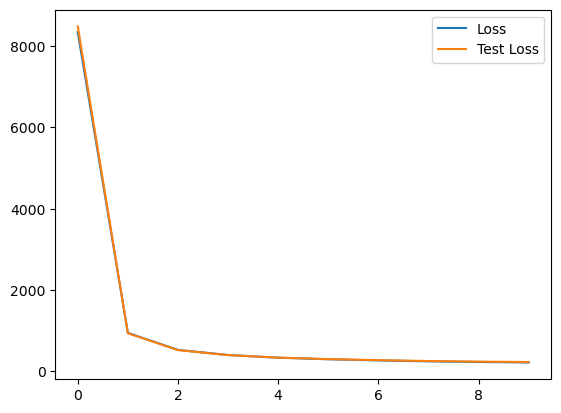

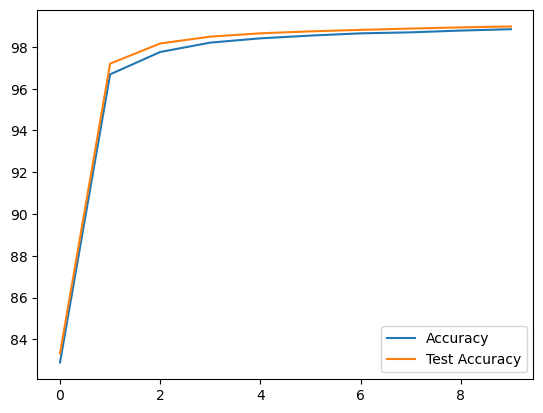

In [5]:
y_pred = torch.argmax(student_model(X_test), dim=1)
misclassifications_to_teacher_model = (y_pred != teacher_y_test).count_nonzero()
misclassifications_to_real_y_test = (y_pred != y_test).count_nonzero()
print(
    f"Misclassification (to Teacher ) in {teacher_y_test.__len__()} pictures: {misclassifications_to_teacher_model} ({(teacher_y_test.__len__()-misclassifications_to_teacher_model)/teacher_y_test.__len__()*100} Accuracy)"
)
print(
    f"Misclassification (to Real Data) in {y_test.__len__()} pictures: {misclassifications_to_real_y_test} ({(y_test.__len__()-misclassifications_to_real_y_test)/y_test.__len__()*100} Accuracy)"
)
plt.plot(torch.tensor(general_loss).cpu(), label="Loss")
plt.plot(torch.tensor(general_test_loss).cpu(), label="Test Loss")
plt.legend()
plt.show()
plt.plot(torch.tensor(general_accuracy).cpu(), label="Accuracy")
plt.plot(torch.tensor(general_test_accuracy).cpu(), label="Test Accuracy")
plt.legend()
plt.show()

# Student 

In [7]:
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

torch.manual_seed(43)
device

'cuda'

In [13]:
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(root="data", train=False, transform=ToTensor())
x_train_not_normalized = train_data.data.float().to(device=device)
y_train = train_data.targets.to(device=device)
x_test_not_normalized = test_data.data.float().to(device=device)
y_test = test_data.targets.to(device=device)

# normalization
x_train = (x_train_not_normalized - x_train_not_normalized.min()) / (
    x_train_not_normalized.max() - x_train_not_normalized.min()
)
x_test = (x_test_not_normalized - x_test_not_normalized.min()) / (
    x_test_not_normalized.max() - x_test_not_normalized.min()
)

train_loader = DataLoader(dataset=list(zip(x_train, y_train)), batch_size=32)
test_loader = DataLoader(dataset=list(zip(x_test, y_test)), batch_size=32)

In [14]:
class Student(nn.Module):
    def __init__(self):
        super(Student, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [15]:
import torch.optim as optim

student = Student().to(device)
optimizer = optim.SGD(student.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [16]:

accuracy = []
for epoch in range(10):
    running_loss = 0.0
    acc = 0
    
    for data in train_loader:
        inputs, truth = data
        optimizer.zero_grad()
        pred = student(inputs.to(device).float())
        truth = truth.to(device)
        loss = criterion(pred, truth)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = torch.argmax(pred, dim=1).float()
        acc += torch.sum(pred == truth).item()
    total_examples = len(train_loader.dataset)
    accuracy.append(acc / total_examples)

    print(f"Epoch {epoch+1}, Loss:{running_loss}")

Epoch 1, Loss:2337.0819381028414
Epoch 2, Loss:718.4296261742711
Epoch 3, Loss:580.4996231161058
Epoch 4, Loss:504.7419978007674
Epoch 5, Loss:447.4154569096863
Epoch 6, Loss:400.2538447184488
Epoch 7, Loss:360.2713991990313
Epoch 8, Loss:325.9272762751207
Epoch 9, Loss:296.4944912851788
Epoch 10, Loss:270.77778948191553


In [23]:
accuracy 

[0.6447833333333334,
 0.8912166666666667,
 0.9118833333333334,
 0.9229833333333334,
 0.9314,
 0.93845,
 0.9446166666666667,
 0.9499166666666666,
 0.9542333333333334,
 0.9583166666666667]

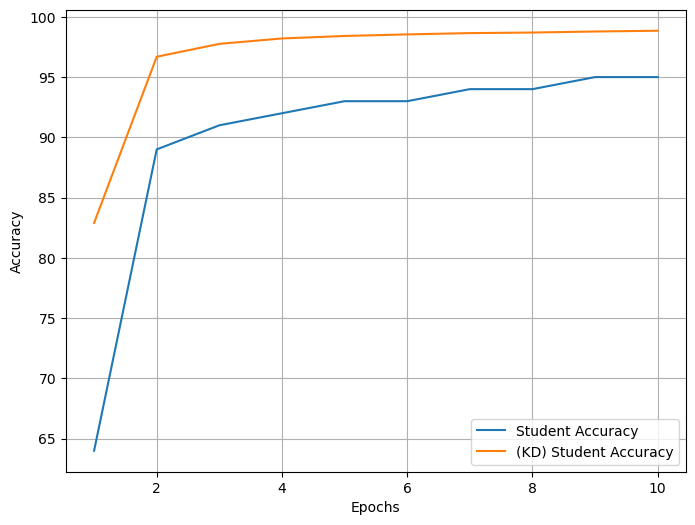

In [25]:
import matplotlib.pyplot as plt
import numpy as np

accuracy_int = [int(acc * 100) for acc in accuracy]


epochs = list(range(1, 11))
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy_int, label='Student Accuracy')
plt.plot(epochs, torch.tensor(general_accuracy).cpu(), label='(KD) Student Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
